In [172]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r") 
        b.set_title(title, fontsize = 14) 
    
        for item in b.get_yticklabels():
            item.set_fontsize(13)

In [174]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using Random forest', 15)
    return base_imp
    

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from rfpimp import *

from sklearn.ensemble.forest import _generate_unsampled_indices
#there is another work that mentions rf feature importance may not be perfect when containing attributes that 
# are of varying scales. Checking again with that method

def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    print(imp)
    return np.array(imp)

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.sort_values('Importance', ascending=False)
    return I

def generate_global_explanations_rf_check(train_X, train_y, cls, feature_combiner):
    feat_names = feature_combiner.get_feature_names()

    rf = clone(cls)
    rf.fit(train_X, train_y)
    train_df = pd.DataFrame(train_X, columns=feat_names)
    y = pd.DataFrame(train_y, columns=['label'])
    oob = oob_classifier_accuracy(rf, train_df, y)
    print("oob accuracy",oob)



    imp = permutation_importances(rf, train_df,y,
                              oob_classifier_accuracy)
    I = mkdf(feat_names,imp)
    print(I.head(10))
    return I;
    #var_imp_plot(I, "Feature importance", 15)


In [176]:
from lime import submodular_pick
def generate_local_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None):
    
    print("Actual value ", test_y)
    num_features=6;# maximum is 6 ,if it is larger than 6, the features displayed are different.
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=num_features, labels=[0,1])
    
    #exp.show_in_notebook(show_table=True, show_all=False);
    print ('Explanation for class %s' % class_names[1])
    print ('\n'.join(map(str, exp.as_list(label=1))))
    return exp
    #%matplotlib inline
    #fig = exp.as_pyplot_figure()
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [177]:

dataset_ref = "bpic2015"
params_dir = "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "rf"
gap = 1
n_iter = 1

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['bpic2015_5_f2']


{'max_features': 0.4143585248113446}
single
Bucket 1
number events 7989
Training model iteration  0
The number of testing instances is  31964
The total number of columns is 349
The total accuracy is  0.9999687148041547
oob accuracy 0.5652357466941951


KeyboardInterrupt: 

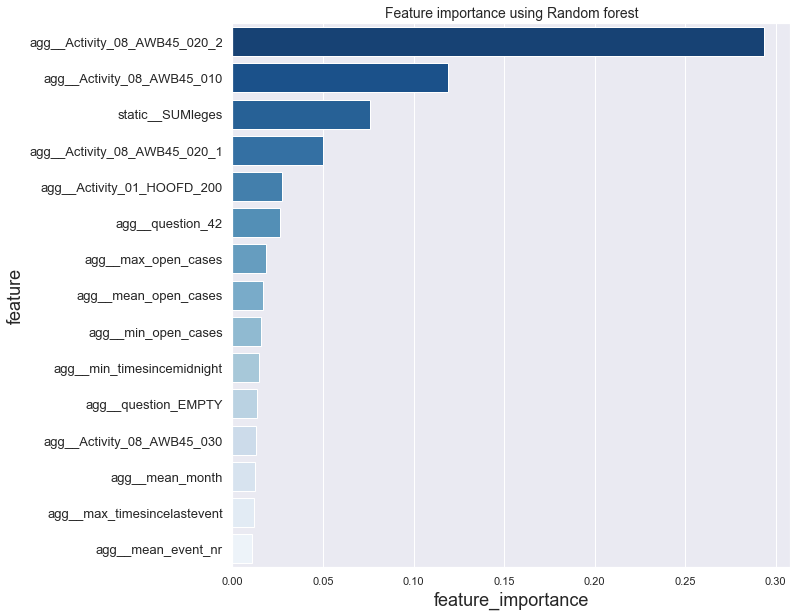

In [181]:
for dataset_name in datasets:
    
    # load optimal params
    optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))
    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        continue
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    
    # read the data
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []
    explained=False
    importance_sk=None
    importance_rfimp=None
    exp_list=[]
    for ii in range(n_iter):
        # create prefix logs
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        bucketer_args = {'encoding_method':bucket_encoding, 
                         'case_id_col':dataset_manager.case_id_col, 
                         'cat_cols':[dataset_manager.activity_col], 
                         'num_cols':[], 
                         'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket )
            if bucket_method == "prefix":
                current_args = args[bucket]
            else:
                current_args = args
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if cls_method == "rf":
                        cls = RandomForestClassifier(n_estimators=500,
                                                     max_features=current_args['max_features'],
                                                     random_state=random_state)

                    elif cls_method == "xgboost":
                        cls = xgb.XGBClassifier(objective='binary:logistic',
                                                n_estimators=500,
                                                learning_rate= current_args['learning_rate'],
                                                subsample=current_args['subsample'],
                                                max_depth=int(current_args['max_depth']),
                                                colsample_bytree=current_args['colsample_bytree'],
                                                min_child_weight=int(current_args['min_child_weight']),
                                                seed=random_state)

                    elif cls_method == "logit":
                        cls = LogisticRegression(C=2**current_args['C'],
                                                 random_state=random_state)

                    elif cls_method == "svm":
                        cls = SVC(C=2**current_args['C'],
                                  gamma=2**current_args['gamma'],
                                  random_state=random_state)

                    if cls_method == "svm" or cls_method == "logit":
                        pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                    else:
                        pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                    pipeline.fit(dt_train_bucket, train_y)
                    #get the explainations for the model now
        
                    print("Training model iteration ", ii )
                    
                    #get the training data as a matrix
                    trainingdata=feature_combiner.fit_transform(dt_train_bucket);
                    importance_sk = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)
                    importance_rfimp = generate_global_explanations_rf_check(trainingdata,train_y, cls, feature_combiner)
                    #create an explainer now that can be passed later
                    class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                    explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata,
                                                    feature_names = feature_combiner.get_feature_names(),
                                                   class_names=class_names, discretize_continuous=True)
                    
                    
                    offline_time_fit += time.time() - start_offline_time_fit

                    # predict separately for each prefix case
                    preds = []
                    
                    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
                    print(dt_test_bucket.shape)
                    count=0
                    for _, group in test_all_grouped:
                        
                        test_y_group = dataset_manager.get_label_numeric(group)
                        test_y_all.extend(test_y_group)
                            
                        start = time.time()
                        _ = bucketer.predict(group)
                        
                        if cls_method == "svm":
                            pred = pipeline.decision_function(group)
                        else:
                            preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                            pred = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                            #print(test_y_group)
                            if group.shape[0] in [5,10,25] and count<3 and test_y_group[0]==1:
                                count=count+1
                                print(group.shape,test_y_group[0], _)
                                test_x_group= feature_combiner.fit_transform(group)
                                
                                test_x=np.transpose(test_x_group[0])
                                print('Generating local Explanations for', dataset_manager.get_case_ids(group))
                                exp=generate_local_explanations(explainer, test_x, cls, test_y_group )
                                exp_list.append(exp)
                        pipeline_pred_time = time.time() - start
                        current_online_event_times.append(pipeline_pred_time / len(group))
                        preds.extend(pred)
                        

            preds_all.extend(preds)

      
   
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                #if nr_events in [5, 10, 25] and explained=False:
                #    generate_local_explanations(explainer,group[j],cls )
                #    explained=True
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))
        

        
            


In [ ]:
%matplotlib inline
for exp in exp_list:
    fig = exp.as_pyplot_figure()

printing global feature importance of the random forest classifier


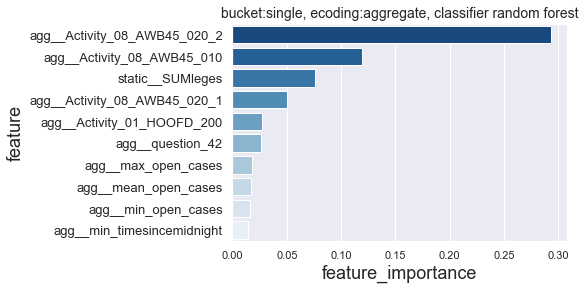

In [168]:
print('printing global feature importance of the random forest classifier') 
var_imp_plot(importance_sk, 'bucket:single, ecoding:aggregate, classifier: random forest', 10)

In [ ]:
print('printing global feature importance of the random forest classifier') 
var_imp_plot(importance_imp, 'bucket:single, ecoding:aggregate, classifier: random forest', 10)

In [171]:
final_data = pd.DataFrame(trainingdata, columns=feature_combiner.get_feature_names())
final_data['target']=train_y


print("Top Absolute Correlations")
au_corr = final_data.corr().abs()
au_corr.fillna(0, inplace=True)
col_names = au_corr.columns
for i in range (0, au_corr.shape[0]):
    test = au_corr.iloc[:,i]
    relevant_feat = test[test>0.95]
    index_list = list(relevant_feat.index.values)
    for idx in index_list:
        if(idx != col_names[i]):
            print(idx ,col_names[i],relevant_feat.loc[idx])

#for i in range(0, au_corr.shape[1]):
#    relevant_features = au_corr[:i]
#    relevant_feat = relevant_features[relevant_features>0.5]
#    print(relevant_feat)

#print(corrplot)
#sns.distplot(corrplot[2], bins=20, kde=False);

Top Absolute Correlations
agg__Activity_01_HOOFD_060 agg__Activity_01_HOOFD_040 0.9638265183165158
agg__Activity_01_HOOFD_040 agg__Activity_01_HOOFD_060 0.9638265183165158
agg__Activity_01_HOOFD_110_2 agg__Activity_01_HOOFD_110_1 0.9662795113460166
agg__Activity_01_HOOFD_110_1 agg__Activity_01_HOOFD_110_2 0.9662795113460166
agg__Activity_01_HOOFD_150 agg__Activity_01_HOOFD_140 0.9766045546008247
agg__Activity_01_HOOFD_140 agg__Activity_01_HOOFD_150 0.9766045546008247
agg__Activity_01_HOOFD_192 agg__Activity_01_HOOFD_191 0.9660111011234332
agg__Activity_01_HOOFD_191 agg__Activity_01_HOOFD_192 0.9660111011234332
agg__Activity_01_HOOFD_260 agg__Activity_01_HOOFD_250 0.9512726130595534
agg__Activity_01_HOOFD_250_2 agg__Activity_01_HOOFD_250_1 0.9594770860900143
agg__Activity_01_HOOFD_250_1 agg__Activity_01_HOOFD_250_2 0.9594770860900143
agg__Activity_01_HOOFD_250 agg__Activity_01_HOOFD_260 0.9512726130595534
agg__Activity_10_UOV_030a agg__Activity_01_HOOFD_460a 0.9511301421909678
agg__Acti

In [163]:
from sklearn.feature_selection import mutual_info_classif

final_data = pd.DataFrame(trainingdata, columns=feature_combiner.get_feature_names())

X = final_data.as_matrix()
y = train_y

c_list = final_data.columns

#c_list = ['agg__Activity_08_AWB45_010','agg__Activity_08_AWB45_020_2','static__SUMleges']

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

for i in range(len(c_list)):
    if mi[i]>=0.3:
        print(c_list[i], 'mi', mi[i])

#plt.figure(figsize=(15, 5))
#for i in range(3):
#    plt.subplot(1, 3, i + 1)
#    plt.scatter(X[:, i], y, edgecolor='black', s=20)
#    plt.xlabel(c_list[i])
#    if i == 0:
#        plt.ylabel("outcome", fontsize=10)
#    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
#              fontsize=16)
#plt.show() 


static__SUMleges mi 0.8287723503898105
agg__Activity_08_AWB45_010 mi 0.41898657699461245
agg__Activity_08_AWB45_020_1 mi 0.38273365387727915
agg__Activity_08_AWB45_020_2 mi 0.5529217630679967
agg__question_42 mi 0.30882522015301883
agg__max_timesincelastevent mi 1.0
agg__max_timesincecasestart mi 0.8935005858161138
agg__min_timesincemidnight mi 0.42769554857302017
agg__sum_timesincelastevent mi 0.9265514112150395
